<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

<h1 style="text-align: center;">Monitoring Biases in a Recommender System</h1>



**Objective**: We want to monitor the prediction of a recommender system usinf the UpTrain framework. Specifically, we want to check how close the predictions of the model are to the ground truth and also check if the model recommendations suffer from any biases (such as the popularity bias).

**Dataset and ML model**: In this example, we train a recommender system to recommend items to users based on their previous shopping history. The dataset is a subset of the [Coveo data challenge dataset](https://github.com/coveooss/SIGIR-ecom-data-challenge) and the model to train embeddings is the [Word2Vec model](https://en.wikipedia.org/wiki/Word2vec). 


Note: Requires [Gensim](https://pypi.org/project/gensim/) to be installed. We ran the following code successfully with Gensim version 4.3.0.

In [1]:
import os
from scipy.spatial.distance import cosine
import numpy as np
import subprocess
import zipfile
import json
import time

import uptrain
from gensim.models import Word2Vec

First, we download the preprocessed SIGIR shopping cart dataset (if not already exists). 

In [2]:
data_file = "sigir_data.json"
remote_url = "https://oodles-dev-training-data.s3.amazonaws.com/sigir_data.json"
if not os.path.exists(data_file):
    try:
        # Most Linux distributions have Wget installed by default.
        # Below command is to install wget for MacOS
        wget_installed_ok = subprocess.call("brew install wget", shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
        print("Successfully installed wget")
    except:
        dummy = 1
    try:
        if not os.path.exists("data.zip"):
            file_downloaded_ok = subprocess.call("wget " + remote_url, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
            print("Data downloaded")
    except:
        print(e)
        print("Could not load training data")
        print("Please follow following steps to manually download data")
        print("Step 1: Open in browser: https://oodles-dev-training-data.s3.amazonaws.com/sigir_data.json")
        print("Step 2: Download and move the file to example location (i.e. uptrain/examples/3_shopping_cart_recommendation/")
else:
    print("Data file exists. Skipping download.")

Data file exists. Skipping download.


In [3]:
with open('sigir_data.json') as f:
    data = json.load(f)

### Step 1: Train the model

Each product has a unique stock-keeping unit (**sku**) that is used as a product identifier. We use [Word2Vec models from Gensim](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to learn a embeddings corresponding to each sku based on shopping sessions of the user.

In [4]:
x_train_sku = [[e['product_sku'] for e in s] for s in data['x_train']]
model = Word2Vec(sentences=x_train_sku, vector_size=48, epochs=15).wv

### Step 2: Define a custom monitor (cosine distance between embeddings of predicted and selected items)

Next, we define a custom metric where we want to monitor the cosine distance between embedding vectors of predicted and selected items. Specifically, we want to measure the cosine distance between the ground truth and first predicted item.

In [5]:
def cosine_dist_init(self):
    self.cos_distances = []
    self.model = model

def cosine_distance_check(self, inputs, outputs, gts=None, extra_args={}):
    for output, gt in zip(outputs, gts):
        if (not output) or (not gt):
            continue
        y_preds = output[0]
        y_gt = gt
        try:
            vector_test = self.model.get_vector(y_gt)
        except:
            vector_test = []
        vector_pred = self.model.get_vector(y_preds)
        if len(vector_pred)>0 and len(vector_test)>0:
            cos_dist = cosine(vector_pred, vector_test)
            self.cos_distances.append(cos_dist)
            self.log_handler.add_histogram('cosine_distance', self.cos_distances, self.dashboard_name)

### Step 3: Define another custom monitor (price difference between predicted and selected items)

Next, we also add a custom metric to measure the absolute log ratio between the ground truth and prediction item prices

In [6]:
def price_homogeneity_init(self):
    self.price_diff = []
    self.product_data = data['catalog']
    self.price_sel_fn=lambda x: float(x['price_bucket']) if x['price_bucket'] else None
    
def price_homogeneity_check(self, inputs, outputs, gts=None, extra_args={}):
    for output, gt in zip(outputs, gts):
        if (not output) or (not gt):
            continue
        y_preds = output[0]
        y_gt = gt
        prod_test = self.product_data[y_gt]
        prod_pred = self.product_data[y_preds]
        if self.price_sel_fn(prod_test) and self.price_sel_fn(prod_pred):
            test_item_price = self.price_sel_fn(prod_test)
            pred_item_price = self.price_sel_fn(prod_pred)
            abs_log_price_diff = np.abs(np.log10(pred_item_price/test_item_price))
            self.price_diff.append(abs_log_price_diff)
            self.log_handler.add_histogram('price_homogeneity', self.price_diff, self.dashboard_name)

### Step 4: Define the prediction pipeline

In [7]:
x_test = data['x_test']
y_test = data['y_test']
inference_batch_size = 10

def model_predict(model, x_test_batch):
    """
    Implement the model prediction function. 
    
    :model: Word2Vec model learned from user shopping sessions
    :x_test_batch: list of lists, each list being the content of a cart
    
    :return: the predictions returned by the model are the top-K
    items suggested to complete the cart.

    """
    predictions = []
    for _x in x_test_batch:
        key_item = _x[0]['product_sku']
        nn_products = model.most_similar(key_item, topn=10) if key_item in model else None
        if nn_products:
            predictions.append([_[0] for _ in nn_products])
        else:
            predictions.append([])

    return predictions

### Step 5: Define UpTrain config and initialize the framework

In [8]:
cfg = {
    "checks": [
        # Check to monitor the hit-rate of the model 
        # (i.e., if any recommended item was selected)
        {
            'type': uptrain.Anomaly.CONCEPT_DRIFT,
            'algorithm': uptrain.DataDriftAlgo.DDM,
            'warn_thres': 2,
            'alarm_thres': 3,
            "measurable_args": {
                'type': uptrain.MeasurableType.REC_HIT_RATE,
                },
        },
        # Define a check on popularity bias
        {
            'type': uptrain.Anomaly.POPULARITY_BIAS,
            'algorithm': uptrain.BiasAlgo.POPULARITY_BIAS,
            'sessions': x_train_sku,   
        },
        # Custom monitor
        {
            'type': uptrain.Anomaly.CUSTOM_MONITOR,
            'initialize_func': cosine_dist_init,
            'check_func': cosine_distance_check,
            'need_gt': True,
            'dashboard_name': 'cosine_distance'
        },
        # Custom monitor
        {
            'type': uptrain.Anomaly.CUSTOM_MONITOR,
            'initialize_func': price_homogeneity_init,
            'check_func': price_homogeneity_check,
            'need_gt': True,
            'dashboard_name': 'price_homogeneity'
        }
    ], 
    "retraining_folder": 'uptrain_smart_data', 
    "st_logging": True,
}

framework = uptrain.Framework(cfg)

Deleting the folder:  uptrain_smart_data


### Step 6: Ship your model in production with UpTrain

In [9]:
for i in range(int(len(x_test)/inference_batch_size)):
    # Define input in the format understood by the UpTrain framework
    inputs = {'data': {"feats": x_test[i*inference_batch_size:(i+1)*inference_batch_size]}}
    
    # Do model prediction
    preds = model_predict(model, inputs['data']['feats'])

    # Log input and output to framework
    ids = framework.log(inputs=inputs, outputs=preds)
    
    # Getting ground truth and logging to framework
    y_test_batch = y_test[i*inference_batch_size:(i+1)*inference_batch_size]
    gts = [y[0]['product_sku'] for y in y_test_batch]
    framework.log(identifiers=ids, gts=gts)
    
    # Adding 1 sec pause to visualize the results live on the dashboard
    time.sleep(1)


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.6.64:8501



### Monitoring the hit-rate of the model

By applying a concept drift check on the model in prediction, UpTrain automatically monitors the performance of the model. In this case, the performance is defined as the hit rate, that is, the proportion of items that was boought by the user was actually recommended by the model. We observe an average hit-rate of around 0.1. 

<img width="600" alt="hit_rate" src="https://user-images.githubusercontent.com/5287871/217215003-e121b499-0e69-4e98-9cd6-2b931cc62056.png">

### Histogram plot for items with popularity

From the UpTrain dashboard, we can find the histogram for popularity bias. We can see that most of the items that are recommended have low popularity. Our model does not look to be suffering from popularity bias.

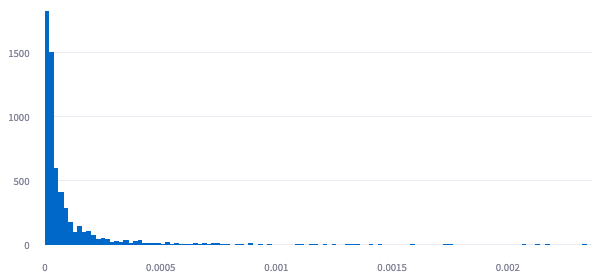

### Histogram plot for cosine distance between ground truth and prediction

In the dashboard, we can measure the cosine distance between the embeddings of the recommended items and the items that were actually bought. A lot of them have zero cosine distance (implying that the recommendations were spot on). Also, we observe that the predictions are concentrated around the low cosine distance (< 0.4) space.

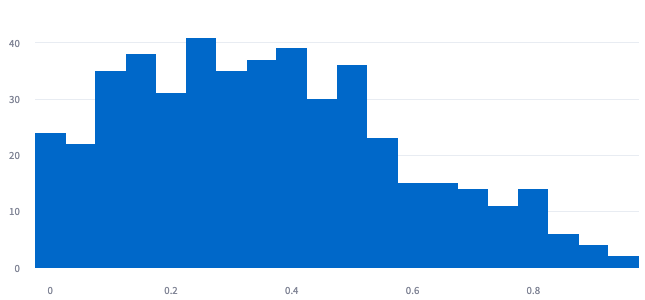

### Histogram plot for absolute log price ratio between prediction and selected items

Finally, we also added a custom monitor where we wanted to check whether our model is providing outrageous recommendations (e.g., recommending washing machines when the user wants to buy just a washing detergent). In the below plot, we observe that the price range of most of the recommended items is close to the price of the actually bought item.

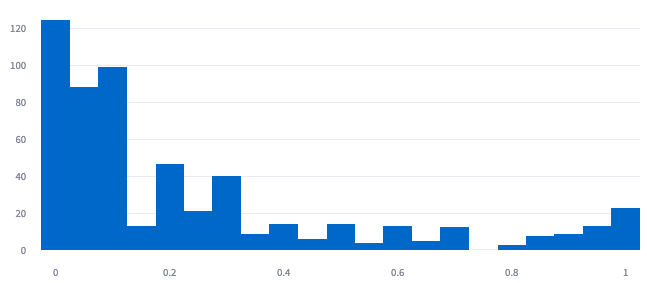